In [1]:
import cxsystem2.neurodynlib as nd
from brian2.units import *
import brian2 as b2
import matplotlib.pyplot as plt

b2.codegen.target = 'numpy'

# Making networks

While neurodynlib is intended for exploring neuron models, you can use it to build network simulations as well. Some knowledge of Brian2 is useful here.

## Create the neuron models

Let's first create the AdEx neuron models for our excitatory and inhibitory neurons using parameters from Naud et al. (2008) Biol Cybern (see tutorial 2 on export/import).

In [2]:
naud2008_json = 'naud2008_table1.json'
exc_neuron = nd.AdexNeuron()
exc_neuron.list_neurons_in_json(naud2008_json)

['cNA',
 'cAD',
 'RS',
 'Fig_4a',
 'Fig_4b',
 'Fig_4c',
 'Fig_4d',
 'Fig_4e',
 'Fig_4f',
 'Fig_4g',
 'Figs_4h']

In [3]:
exc_neuron.read_json(naud2008_json, 'RS')

In [4]:
inh_neuron = nd.AdexNeuron()
inh_neuron.read_json(naud2008_json, 'cNA')

In [5]:
exc_neuron.add_tonic_current(45*pA)
inh_neuron.add_tonic_current(85*pA)

Let's finally add some synaptic receptors (see tutorial 3 on synapses).

In [6]:
exc_receptor_model = 'SIMPLE_E'
inh_receptor_model = 'SIMPLE_I'

In [7]:
exc_neuron.set_excitatory_receptors(exc_receptor_model)
exc_neuron.set_inhibitory_receptors(inh_receptor_model)
inh_neuron.set_excitatory_receptors(exc_receptor_model)
inh_neuron.set_inhibitory_receptors(inh_receptor_model)

In [8]:
exc_neuron.set_neuron_parameters(tau_e=3.0*ms, tau_i=8.0*ms, Ee=0*mV, Ei=-80*mV)
inh_neuron.set_neuron_parameters(tau_e=3.0*ms, tau_i=8.0*ms, Ee=0*mV, Ei=-80*mV)

## Create neuron populations

We can now create excitatory and inhibitory neuron populations using the parameters defined above.

In [9]:
exc_pop = exc_neuron.make_neuron_group(3200)
inh_pop = inh_neuron.make_neuron_group(800)

In [10]:
exc_pop

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')

## Connecting the groups

The neuron populations are connected using Brian2's Synapses object. 
For more information on how to create synapses in Brian2, please see https://brian2.readthedocs.io/en/stable/user/synapses.html.

In [11]:
exc_weight = 0.05*nS
inh_weight = 1.0*nS
Syn_EE = b2.Synapses(exc_pop, exc_pop, on_pre='ge_post += exc_weight')
Syn_EI = b2.Synapses(exc_pop, inh_pop, on_pre='ge_post += exc_weight')
Syn_IE = b2.Synapses(inh_pop, exc_pop, on_pre='gi_post += inh_weight')
Syn_II = b2.Synapses(inh_pop, inh_pop, on_pre='gi_post += inh_weight')

In [12]:
Syn_EE.connect(p=0.05)
Syn_EI.connect(p=0.05)
Syn_IE.connect(p=0.2)
Syn_II.connect(p=0.2)

## Creating monitors and setting the initial values

Finally, we can define what variables we want to record during the simulation. For more information on Brian2's monitors, please see https://brian2.readthedocs.io/en/stable/user/recording.html.

In [13]:
exc_spikes = b2.SpikeMonitor(exc_pop)
inh_spikes = b2.SpikeMonitor(inh_pop)
exc_rate = b2.PopulationRateMonitor(exc_pop)
inh_rate = b2.PopulationRateMonitor(inh_pop)
exc_vm = b2.StateMonitor(exc_pop, ['vm'], record=True)
inh_vm = b2.StateMonitor(inh_pop, ['vm'], record=True)

Let's randomize initial membrane voltages (randn = normal distribution with mean 0 and sd 1). 

In [14]:
exc_pop.vm = 'VT + rand()*(VT-EL)'
inh_pop.vm = 'VT + rand()*(VT-EL)'
exc_pop.ge = 'rand()*exc_weight'

## Running the simulation

In [15]:
b2.run(5000*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]


## Visualize results

In [16]:
from brian2tools import brian_plot

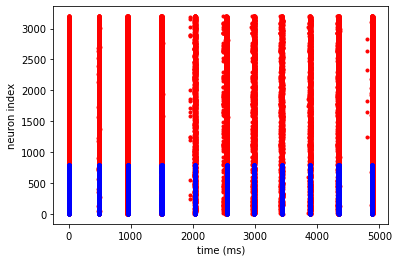

In [17]:
plt.Figure()
ax = plt.gca()
brian_plot(exc_spikes, axes=ax, c='red')
brian_plot(inh_spikes, axes=ax, c='blue')